# Photo checker

This project checks which of our family photos are "good" or "bad". We have nearly 80,000 photos, so it's not practical to sort them out by hand. I want to exclude screenshots, photos of computer screens, photos of papers, images with lots of text, and very blurry images. I used this to separate the good photos to use for a random slide show on our TV. The trained model achieves around 99% accuracy on the validation set.

## Setup

In [1]:
! [ -e /content ] && pip install -Uqq fastbook

In [9]:
from fastbook import *
from fastai.vision.widgets import *

In [10]:
#|export
from fastai.vision.all import *

In [11]:
photos_tree = Path('gphotos-sync-400').resolve()
photos = Path('photos').resolve()
photos_set = Path('photos-set')
done = Path('photos-done')
photos.mkdir(exist_ok=True)
photos_set.mkdir(exist_ok=True)
done.mkdir(exist_ok=True)

path = done

## Photo-set wrangling

First I resized all the photos to be no larger than 400 on the small size, using imagemagick, something like:

In [ ]:
!magick convert large.jpg -resize 400x400^ small.jpg

I made numbered symlinks to all the images, and moved and copied the symlinks not the images during training. I did the training in several stages, with increasingly large sets of photos. I edited and ran the following cells as needed to achieve the task.

In [3]:
fns_all = sorted(get_image_files(photos_tree))
n_all = len(fns_all); n_all

79422

In [4]:
failed = verify_images(fns_all)
len(failed), failed

(0, (#0) [])

In [7]:
failed.map(Path.unlink);

In [31]:
for i, fn in enumerate(fns_all):
    name = f"{i:05}.jpg"
    Path(photos/name).symlink_to(photos_tree.parent/fn)

In [32]:
for i in range(79000, n_all):
    name = f"{i:05}.jpg"
    shutil.copy(photos/name, photos_set/name, follow_symlinks=False)

I sorted into bad and good dirs with [qiv](https://linux.die.net/man/1/qiv) and filer windows here.

In [14]:
fns = get_image_files(path)
len(fns)

1421

In [4]:
def random_split(path, valid_pct=0.2):
    for cl in 'bad', 'good':
        for set in 'train', 'valid':
            Path(path/set/cl).mkdir(exist_ok=True, parents=True)
        fns = get_image_files(path/cl)
        random.shuffle(fns)
        n = len(fns) ; c = int(valid_pct * n)
        for fn in fns[0:c]:
            shutil.move(fn, path/'valid'/cl)
        for fn in fns[c:n]:
            shutil.move(fn, path/'train'/cl)
    for cl in 'bad', 'good':
        (path/cl).rmdir()

In [ ]:
random_split(photos_set)

In [55]:
# after training
!mkdir -p photos-done/{train,valid}/{good,bad}
!mv -i photos-set/train/good/* photos-done/train/good/
!mv -i photos-set/train/bad/* photos-done/train/bad/
!mv -i photos-set/valid/good/* photos-done/valid/good/
!mv -i photos-set/valid/bad/* photos-done/valid/bad/

In [46]:
for i in range(79000, n_all):
    name = f"{i:05}.jpg"
    shutil.copy(photos/name, photos_set/name, follow_symlinks=False)

In [8]:
torch.cuda.empty_cache()

## Classification inference

After each training, I exported the model and used it with my [classify](https://sam.ucm.dev/t/bin.ai/classify) script to classify the next set of photos. I then checked and corrected the classifications, which wasn't too difficult, as the model was around 99% accurate at each stage after re-training.

In [48]:
!cd photos-set; ls *.jpg | classify --move 0.7 --model ../photos.pkl > class.txt

## Data block and data loaders

Load and preview the current set of photos.

In [36]:
datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))

In [37]:
dls = datablock.dataloaders(path, bs=64)

In [38]:
len(dls.items), len(dls.valid.items)

(63543, 15879)

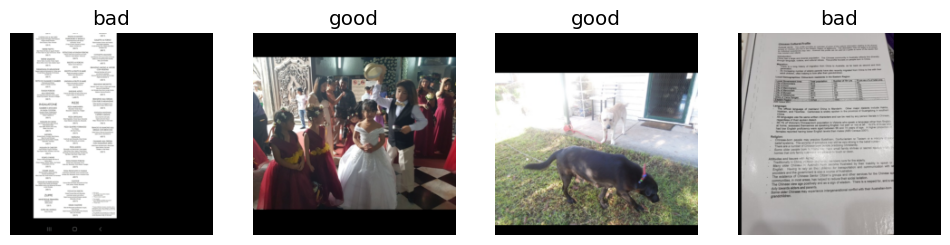

In [45]:
dls.show_batch(max_n=4, nrows=1)

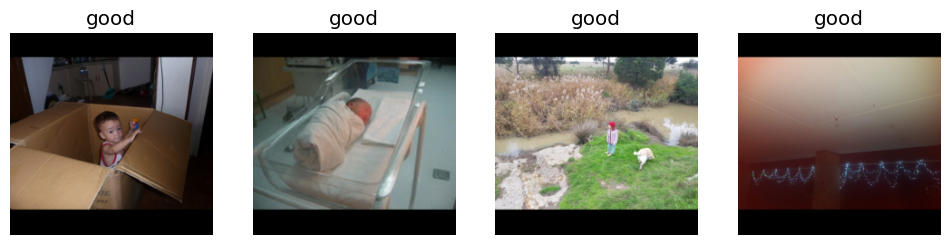

In [46]:
dls.valid.show_batch(max_n=4, nrows=1)

## Create and train a resnet34 learner

In [47]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

In [48]:
learn.fine_tune(2)

## Export the trained model

In [16]:
learn.export("photos.pkl")

## Load the model, and set the data loaders

I experimented with re-training the existing model with new data, but I got better results starting over.

In [2]:
#|export
learn = load_learner('photos.pkl')

In [25]:
learn.dls = dls

## Check the confusion matrix and top losses

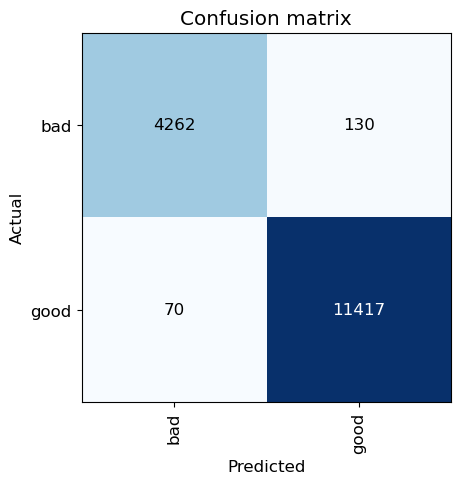

In [52]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

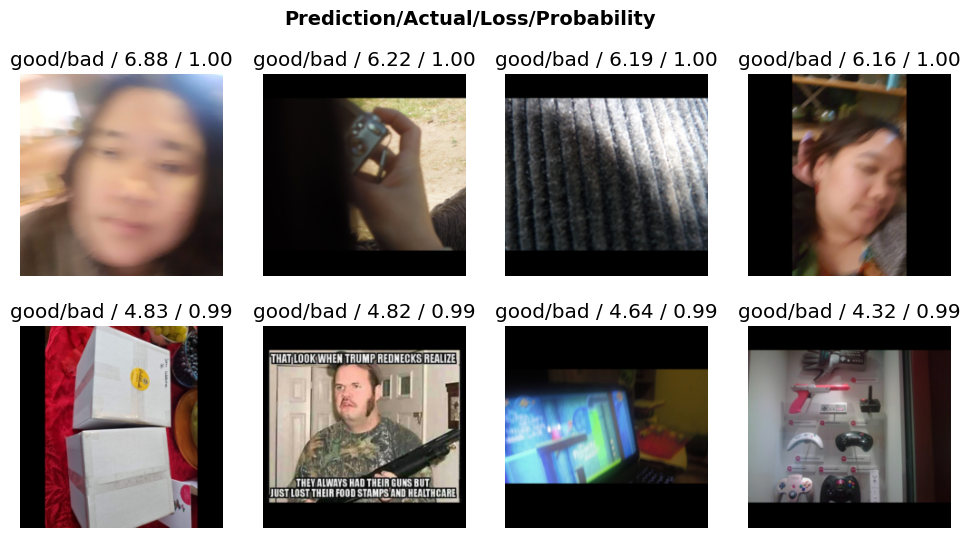

In [53]:
interp.plot_top_losses(8, nrows=2)

## Run the cleaner

Run the cells to delete and move images after each section. It seems to reset the lists when we select a new section in the drop down lists. So we may need to run the cells four times: train,good; train,bad; valid,good; valid,bad.

In [54]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): print(cleaner.fns[idx])

In [ ]:
for idx, cl in cleaner.change(): print(cleaner.fns[idx])

In [ ]:
for idx in cleaner.delete():
    try:
        cleaner.fns[idx].unlink()
    except Exception as e:
        print(e)

In [ ]:
for idx, cl in cleaner.change():
    try:
        section = cleaner.fns[idx].parent.parent.name
        shutil.move(cleaner.fns[idx], path/section/cl/cleaner.fns[idx].name)
    except Exception as e:
        print(e)

In [112]:
learn.export("photos.pkl")

## Create an app from the model

The following method using ipywidgets and voila worked locally, but I did not yet succeed with deploying it on mybinder as described in the book. I then checked the [lesson 2 for 2022](https://course.fast.ai/Lessons/lesson2.html), and deployed it as a gradio app on huggingface spaces as recommended.

In [64]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [66]:
img = PILImage.create(btn_upload.data[-1])

In [67]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [68]:
pred,pred_idx,probs = learn.predict(img)

In [69]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: good; Probability: 0.9996')

In [70]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [71]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [72]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

In [6]:
#|export
labels = learn.dls.vocab

In [5]:
labels

['bad', 'good']

In [8]:
#|export
def classify_image(img):
	img = PILImage.create(img)
	pred,idx,probs = learn.predict(img)
	return dict(zip(labels, map(float, probs)))

In [9]:
#|export
import gradio as gr

iface = gr.Interface(
	title = "Photo Checker",
	description = """This project checks which of our family photos are "good" or "bad". We have nearly 80,000 photos, so it's not practical to sort them out by hand. I want to exclude screenshots, photos of computer screens, photos of papers, images with lots of text, and very blurry images. I used this to separate the good photos to use for a random slide show on our TV. The trained model achieves around 99% accuracy on the validation set.""",
	fn = classify_image,
	inputs = gr.inputs.Image(shape = (512,512)),
	outputs = gr.outputs.Label(num_top_classes = 3),
	examples = list(map(str, get_image_files('eg'))),
	interpretation='default',
	enable_queue=True,
)

iface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `enable_queue` is deprecated in `Interface()`, please use it within `launch()` instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f4a2139bac0>, 'http://127.0.0.1:7860/', None)

In [12]:
#| default_exp app

In [13]:
from nbdev.export import nb_export
nb_export('photo-checker.ipynb', '.')